# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./readonly/small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [1]:
import zipfile
from PIL import Image, ImageFont, ImageDraw
import io
import pytesseract
import cv2 as cv
import numpy as np
import math
from collections import Counter
import string
# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

# the rest is up to you!

### Functions and classes

In [2]:
def fit_image(image, pic_size):
    factors = [image.size[n]/pic_size[n] for n in range(len(pic_size))]
    factor = max(factors)
    if factor > 1:
        return image.resize((int(image.size[0]/factor), int(image.size[1]/factor)))
    else:
        return image

In [3]:
def collage(images, pic_size=(125, 125), width=5, title='Face collage.'):
    height = math.ceil(len(images)/width)
    text_size=20
    text_lines = 1 if images else 2
    mode = images[0].mode if images else 'RGB'
    text = title if images else title + "\nBut there were no faces in that file!"
    textbox = Image.new(mode, (pic_size[0]*width, text_lines*text_size+5), 'white')
    drawing = ImageDraw.Draw(textbox)
    
    fnt = ImageFont.truetype('readonly/fanwood-webfont.ttf', text_size)
    drawing.text((0,0), text, font=fnt, fill='black')
    composite_image = Image.new(mode, (textbox.width, pic_size[1]*height + textbox.height))
    composite_image.paste(textbox)

    x, y = (0, textbox.height)
    for image in images:
        composite_image.paste(fit_image(image, pic_size), (x,y))
        x += pic_size[0]
        if x >= composite_image.size[0]:
            x = 0
            y += pic_size[1]
        
    return composite_image

In [4]:
def show_rects(faces, pil_img):
    #Lets read in our gif and convert it
#     pil_img=Image.open('readonly/msi_recruitment.gif').convert("RGB")
    # Set our drawing context
    working_image = pil_img.copy()
    drawing=ImageDraw.Draw(working_image)
    # And plot all of the rectangles in faces
    for x,y,w,h in faces:
        drawing.rectangle((x,y,x+w,y+h), outline="lime", width=5)
    #Finally lets display this
    display(working_image)

In [5]:
def detect_faces(image, scale=1.3, neighbours=5):
    """ Detect faces in a PIL image,returns list of rectanges."""
    opencvImage = cv.cvtColor(np.array(image), cv.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(opencvImage, scaleFactor=scale, minNeighbors=neighbours)
    return faces

In [6]:
class Article(object):
    def __init__(self, image, name = ''):
        self.name = name
        if isinstance(image, Image.Image):
            print('From Image')
            self.image = image
        elif isinstance(image, zipfile.ZipExtFile):
            self.name = image.name if not name else name
            print(f'From zipfile {self.name}')
            self.image = Image.open(image)
        elif isinstance(image, io.IOBase):
            print('From file')
            self.image = Image.open(image)
        else:
            raise ArchiveError('Unknown source type')
        self.ocr_run = False
        self.text = ''
        self.words = list()
        self.word_list = list()
        self.tokenize()
        self._faces = []
        self._face_boxes = []
        self.face_detection_run = False
        
    def ocr(self, config='psm 3'):
        # ToDo: improve recognition with preprocessing
        self.text = pytesseract.image_to_string(self.image, config=config)
        self.ocr_run = True
        return self.text
    
    def tokenize(self):
        if not self.ocr_run:
            _ = self.ocr()
        text = ''.join(l if l not in string.punctuation + '’'
                   else ' ' for l in self.text)
        self.word_list = Counter(text.split())
        self.words = self.word_list.keys()
#         [w.lower() for w in self.word_list.keys()]
    
    def __str__(self):
        return f"Article with {len(self.words)} words.\nFaces:\n{len(self._faces)}"
    
    def display(self):
        print("Name: ", self.name)
        display(self.image)
        
    def detect_faces(self):
        self._face_boxes = detect_faces(self.image)
        # ToDo: copy faces as images
        self._faces = [self.image.crop((x, y, x+w, y+h))
                       for x,y,w,h in self._face_boxes]
        self.face_detection_run = True
        
    @property
    def faces(self):
        if not self.face_detection_run:
            self.detect_faces()
        return self._faces

In [7]:
def scan_archive(archive):
    articles = []
    for f in archive.filelist:
        scan = archive.open(f)
        articles.append(Article(scan))
    return articles

In [8]:
def search_article(term, articles):
    """ Search a collection of articles for snippets, displaying faces from the articel"""
    for article in articles:
#         print(f'Searching {article.name}...')
#         if term in article.words:

        if term in (w[0:len(term)] for w in article.words):
            display(collage(article.faces, title=f'Results found in file {article.name}'))

### Loading and searching
Not happy with the search algorithm, but it produces the desired results.

In [9]:
archive = zipfile.ZipFile('readonly/small_img.zip')
archive_large = zipfile.ZipFile('readonly/images.zip')
article_all = scan_archive(archive_large)
article_small = scan_archive(archive)

From zipfile a-0.png
From zipfile a-1.png
From zipfile a-10.png
From zipfile a-11.png
From zipfile a-12.png
From zipfile a-13.png
From zipfile a-2.png
From zipfile a-3.png
From zipfile a-4.png
From zipfile a-5.png
From zipfile a-6.png
From zipfile a-7.png
From zipfile a-8.png
From zipfile a-9.png
From zipfile a-0.png
From zipfile a-1.png
From zipfile a-2.png
From zipfile a-3.png


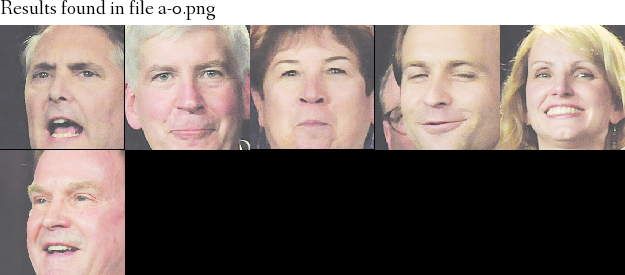

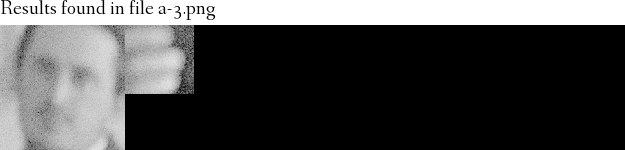

In [11]:
search_article('Chris', article_small)

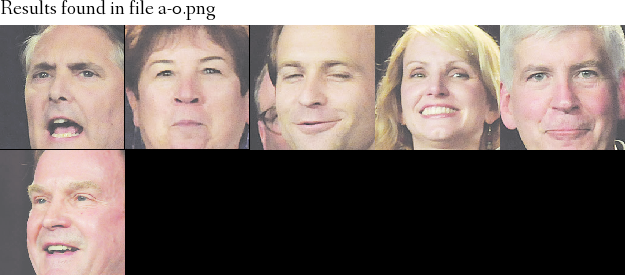

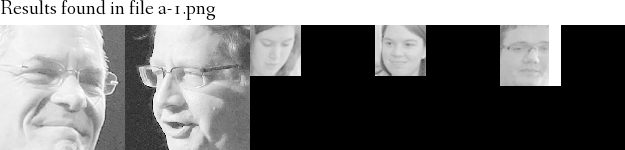

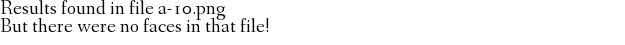

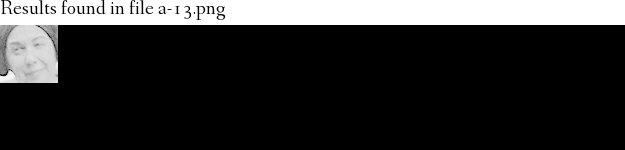

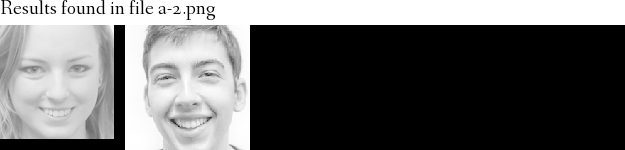

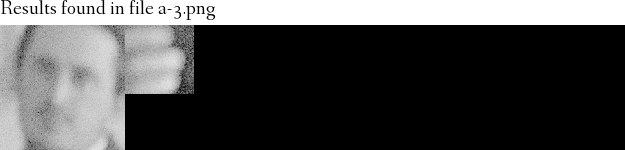

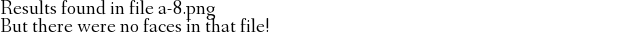

In [12]:
search_article('Mark', article_all)